In [10]:
# Define the path to GEO file
import gzip
import pandas as pd

# Load GEO data from .txt.gz file
geo_file = "data/GSE45827_series_matrix.txt.gz"

# Skip the metadata lines at the top and read the expression data
with gzip.open(geo_file, 'rt', encoding='ISO-8859-1') as f:
    lines = f.readlines()

# Find the start and end of the table
start = None
end = None
for i, line in enumerate(lines):
    if "!series_matrix_table_begin" in line:
        start = i + 1
    elif "!series_matrix_table_end" in line:
        end = i
        break

# Read only the expression data between those lines
expression_data = pd.read_csv(
    geo_file,
    sep="\t",
    skiprows=start,
    nrows=end-start-1,
    index_col=0,
    compression='gzip',
    encoding='ISO-8859-1'
)
expression_T = expression_data.T
# Display the top of the dataset
expression_data.head()


,GSM1116084,GSM1116085,GSM1116086,GSM1116087,GSM1116088,GSM1116089,GSM1116090,GSM1116091,GSM1116092,GSM1116093,...,GSM1116229,GSM1116230,GSM1116231,GSM1116232,GSM1116233,GSM1116234,GSM1116235,GSM1116236,GSM1116237,GSM1116238
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,9.47065,9.67440,10.20800,10.11420,11.16360,10.00690,9.53932,9.00187,6.54074,10.35510,...,9.96811,10.10680,10.03290,9.84599,10.75850,10.55470,9.45290,10.80010,10.04640,11.42010
1053_at,8.36311,8.72194,7.78601,9.44537,7.71242,7.84274,7.56238,8.01540,9.37874,9.45426,...,7.25745,7.54377,7.41607,5.83454,8.83376,6.88277,6.83700,7.29371,7.71122,7.63877
117_at,5.95426,7.02523,6.39671,4.56023,5.29008,6.21590,6.42180,6.23554,5.43541,3.85652,...,8.35832,6.98743,4.50611,4.78051,4.55847,4.14597,6.10766,5.41169,4.57742,4.67159
1294_at,6.02119,7.24581,6.85310,5.42786,7.51120,5.79719,7.36700,7.17268,7.72472,4.79560,...,7.18591,7.74070,7.44448,7.03001,6.87039,6.37882,6.99674,8.37598,6.56774,7.40374
1316_at,3.22997,3.29352,3.26204,3.34766,3.59086,3.40108,3.27663,3.14212,3.28420,3.27900,...,3.50312,3.57309,3.31572,3.70289,4.82208,3.55309,3.23899,3.84879,3.28091,3.24882


In [11]:
#Step 1: Look at the first 60 lines to find the subtype information
for i, line in enumerate(lines[:60]):
    print(f"{i}: {line.strip()}")

0: !Series_title	"Expression data from Breast cancer subtypes"
1: !Series_geo_accession	"GSE45827"
2: !Series_status	"Public on Mar 24 2016"
3: !Series_submission_date	"Apr 05 2013"
4: !Series_last_update_date	"Mar 25 2019"
5: !Series_pubmed_id	"27006338"
6: !Series_summary	"Expression data from Breast cancer subtypes"
7: !Series_overall_design	"In a cohort study of primary invasive breast cancer (41 TN, 30 HER2, 29 Luminal A and 30 Luminal B) as well as 11 normal tissues samples and 14 cell lines , we obtained a tumor specimen at surgery before any patient treatment. Total RNA was extracted from all samples and the whole transcriptome was quantified with Affymetrix U133 Plus 2.0 Chips."
8: !Series_type	"Expression profiling by array"
9: !Series_contributor	"Tina,,Gruosso"
10: !Series_contributor	"Yann,,Kieffer"
11: !Series_contributor	"Thierry,,Dubois"
12: !Series_contributor	"Fatima,,Mechta-Grigoriou"
13: !Series_sample_id	"GSM1116084 GSM1116085 GSM1116086 GSM1116087 GSM1116088 GSM11

In [12]:
# Step 2: Load subtype and sample ID lines (line 31 and 32 in the file)
sample_titles_line = lines[31].strip().split("\t")[1:]  # remove "!Sample_title"
sample_ids_line = lines[32].strip().split("\t")[1:]     # remove "!Sample_geo_accession"

# Step 3: Clean and extract subtype and sample IDs
subtypes = [title.split()[0].replace('"', '') for title in sample_titles_line]
sample_ids = [sid.replace('"', '').strip() for sid in sample_ids_line]

# Step 4: Create a clean DataFrame mapping each sample ID to its subtype
import pandas as pd
sample_info = pd.DataFrame({
    'Sample': sample_ids,
    'Subtype': subtypes
})
sample_info.set_index('Sample', inplace=True)

# Step 5: View the first few rows
sample_info.head()

,Subtype
Sample,
GSM1116084,Basal
GSM1116085,Basal
GSM1116086,Her2
GSM1116087,Basal
GSM1116088,Her2


In [13]:
# Also clean expression_T if you haven’t already
expression_T.index = expression_T.index.str.strip().str.replace('"', '')

# Test if they match
assert all(expression_T.index == sample_info.index)

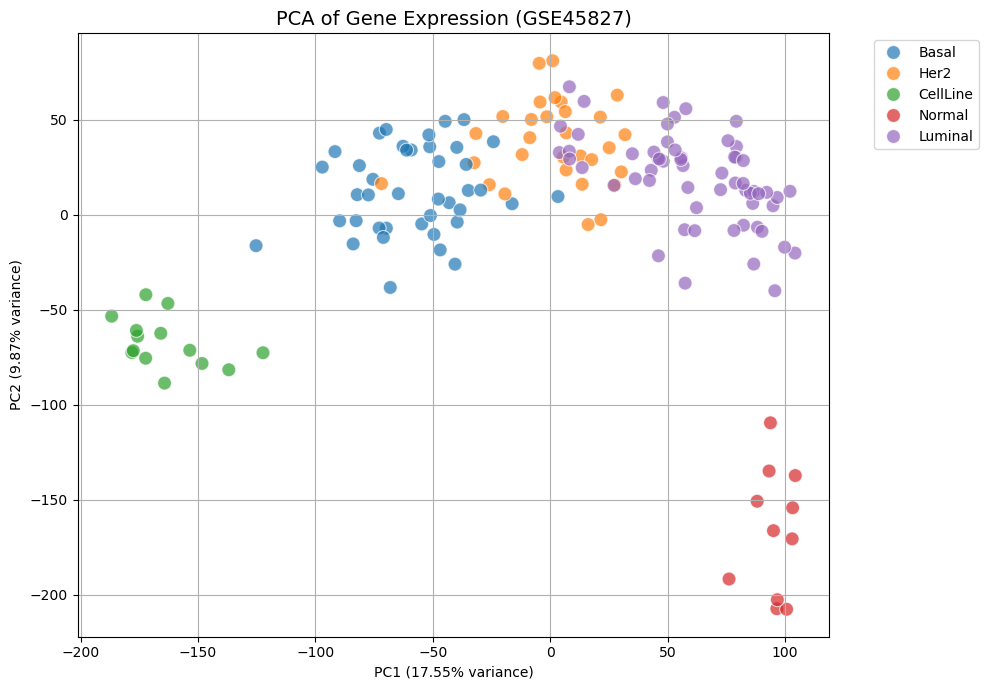

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(expression_T)

# Step 2: Build a DataFrame to hold PCA results and subtype info
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Subtype': sample_info['Subtype'].values
}, index=expression_T.index)

# Step 3: Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Subtype',
    palette='tab10',
    data=pca_df,
    s=100, alpha=0.7
)
plt.title('PCA of Gene Expression (GSE45827)', fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# GOAL: Identify differentially expressed genes (DEGs) between: 1.Basal breast cancer samples - 2.Luminal A breast cancer samples
# We’ll calculate:
# log₂ fold change between groups
# t-test p-values
# Then visualize top genes in a volcano plot

from scipy.stats import ttest_ind
import numpy as np

# Step 1: Subset samples
basal_samples = sample_info[sample_info['Subtype'] == 'Basal'].index
luminal_samples = sample_info[sample_info['Subtype'] == 'Luminal'].index  # includes both Luminal A/B
# Clean titles and IDs
title_line = lines[31].strip().split("\t")[1:]
id_line = lines[32].strip().split("\t")[1:]

titles_clean = [t.replace('"', '') for t in title_line]
ids_clean = [i.replace('"', '') for i in id_line]

# Match sample IDs to titles
title_lookup = dict(zip(ids_clean, titles_clean))

# Now extract by subtype keyword
basal_samples = [sample for sample in ids_clean if 'Basal' in title_lookup[sample]]
luminalA_samples = [sample for sample in ids_clean if 'Luminal A' in title_lookup[sample]]

# Optional check
print("Basal:", len(basal_samples))
print("Luminal A:", len(luminalA_samples))

# Step 2: Subset expression data
basal_expr = expression_T.loc[basal_samples]
luminalA_expr = expression_T.loc[luminalA_samples]

# Step 3: Run t-test across genes
p_values = []
log2_fc = []

for gene in expression_T.columns:
    basal_vals = basal_expr[gene]
    luminal_vals = luminalA_expr[gene]
    
    # Calculate p-value
    stat, p = ttest_ind(basal_vals, luminal_vals, equal_var=False)
    p_values.append(p)
    
    # Calculate log2 fold change (mean ratio)
    fc = basal_vals.mean() / (luminal_vals.mean() + 1e-6)  # avoid div by zero
    log2_fc.append(np.log2(fc))

# Step 4: Compile results
deg_df = pd.DataFrame({
    'Gene': expression_T.columns,
    'log2FC': log2_fc,
    'p_value': p_values
})
deg_df['-log10(p_value)'] = -np.log10(deg_df['p_value'])


Basal: 41
Luminal A: 29


In [16]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
print("Running sample extraction code...")

title_line = lines[31].strip().split("\t")[1:]
id_line = lines[32].strip().split("\t")[1:]

titles_clean = [t.replace('"', '') for t in title_line]
ids_clean = [i.replace('"', '') for i in id_line]

title_lookup = dict(zip(ids_clean, titles_clean))

basal_samples = [sample for sample in ids_clean if 'Basal' in title_lookup[sample]]
luminalA_samples = [sample for sample in ids_clean if 'Luminal A' in title_lookup[sample]]

print("Basal samples:", len(basal_samples))
print("Luminal A samples:", len(luminalA_samples))



Running sample extraction code...
Basal samples: 41
Luminal A samples: 29


In [17]:
# Subset expression data for these samples
basal_expr = expression_T.loc[basal_samples]
luminalA_expr = expression_T.loc[luminalA_samples]

print("Basal expression data shape:", basal_expr.shape)
print("Luminal A expression data shape:", luminalA_expr.shape)


Basal expression data shape: (41, 29873)
Luminal A expression data shape: (29, 29873)


In [18]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

p_values = []
log2_fc = []
tested_genes = 0

for gene in expression_T.columns:
    basal_vals = basal_expr[gene]
    luminal_vals = luminalA_expr[gene]
    
    # Lowered threshold for testing
    if basal_vals.notna().sum() < 2 or luminal_vals.notna().sum() < 2:
        p_values.append(np.nan)
        log2_fc.append(np.nan)
        continue
    
    stat, p = ttest_ind(basal_vals, luminal_vals, equal_var=False)
    fold_change = basal_vals.mean() / (luminal_vals.mean() + 1e-6)
    log2_fold_change = np.log2(fold_change)
    
    p_values.append(p)
    log2_fc.append(log2_fold_change)
    tested_genes += 1

print(f"T-tests completed on {tested_genes} genes")
print("Length of p_values:", len(p_values))
print("Length of log2_fc:", len(log2_fc))
print("Valid p-values count:", sum(pd.Series(p_values).notna()))

deg_df = pd.DataFrame({
    'Gene': expression_T.columns,
    'log2FC': log2_fc,
    'p_value': p_values
})

deg_df['-log10(p_value)'] = -np.log10(deg_df['p_value'].replace(0, np.nan))

deg_df_sorted = deg_df.sort_values(by='p_value').head(10)

print("deg_df shape:", deg_df.shape)
print("deg_df sorted shape:", deg_df_sorted.shape)
print(deg_df_sorted)


T-tests completed on 29873 genes
Length of p_values: 29873
Length of log2_fc: 29873
Valid p-values count: 29873
deg_df shape: (29873, 4)
deg_df sorted shape: (10, 4)
              Gene    log2FC       p_value  -log10(p_value)
22364    228241_at -2.261937  6.652708e-38        37.177002
16985  221591_s_at  1.586367  1.304302e-37        36.884622
18958  224428_s_at  1.518194  1.524021e-35        34.817009
6063   204318_s_at  1.068765  2.453649e-35        34.610188
9227     209464_at  1.192451  1.579078e-34        33.801597
10094  210735_s_at -1.669860  2.057425e-34        33.686676
5232     203418_at  1.650598  3.136787e-34        33.503515
10303  211110_s_at -1.643408  3.542610e-34        33.450677
20874    226473_at  1.830315  9.284239e-34        33.032254
1361    1558447_at -1.442217  8.079803e-33        32.092599


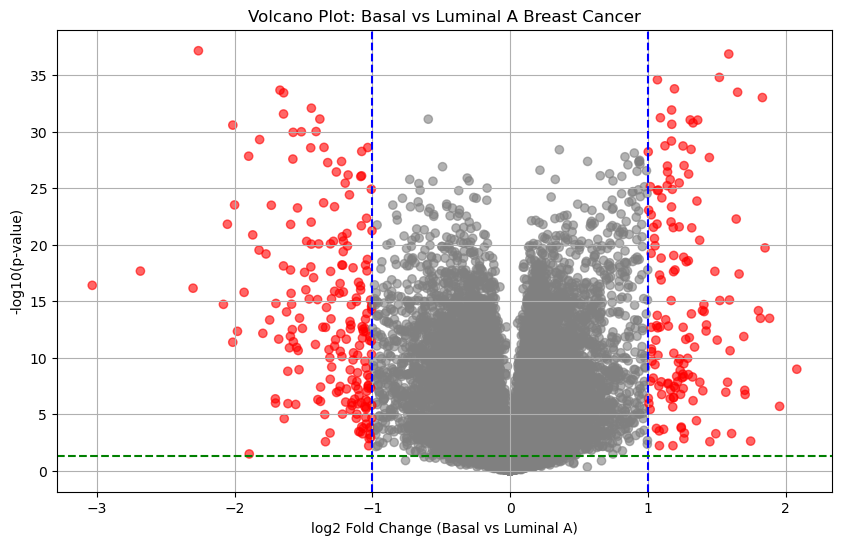

In [19]:
import matplotlib.pyplot as plt

# Define thresholds
fc_threshold = 1     # absolute log2 fold change > 1
pval_threshold = 0.05

# Determine significance
deg_df['Significant'] = (
    (deg_df['p_value'] < pval_threshold) &
    (deg_df['log2FC'].abs() > fc_threshold)
)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(deg_df['log2FC'], deg_df['-log10(p_value)'], 
            c=deg_df['Significant'].map({True: 'red', False: 'gray'}),
            alpha=0.6)

plt.axvline(x=fc_threshold, color='blue', linestyle='--')
plt.axvline(x=-fc_threshold, color='blue', linestyle='--')
plt.axhline(y=-np.log10(pval_threshold), color='green', linestyle='--')

plt.xlabel('log2 Fold Change (Basal vs Luminal A)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Basal vs Luminal A Breast Cancer')
plt.grid(True)
plt.show()


In [20]:
import gzip
import pandas as pd

annot_file = "data/GPL570.annot.gz"

# Step 1: Keep only relevant columns
annotation_df = annotation_df[['ID', 'Gene symbol']].dropna()

# Step 2: Remove rows where gene symbol is missing or empty
annotation_df = annotation_df[annotation_df['Gene symbol'] != '']

# Step 3: Preview cleaned annotation
annotation_df.head()


,ID,Gene symbol
0,1007_s_at,MIR4640///DDR1
1,1053_at,RFC2
2,117_at,HSPA6
3,121_at,PAX8
4,1255_g_at,GUCA1A


In [21]:
# Create mapping dictionary
probe_to_gene = dict(zip(annotation_df['ID'], annotation_df['Gene symbol']))
print("Sample probe-to-gene mappings:")
for i, (probe, gene) in enumerate(probe_to_gene.items()):
    print(f"{probe} -> {gene}")
    if i >= 5:  # show only first 6 mappings
        break


Sample probe-to-gene mappings:
1007_s_at -> MIR4640///DDR1
1053_at -> RFC2
117_at -> HSPA6
121_at -> PAX8
1255_g_at -> GUCA1A
1294_at -> MIR5193///UBA7


In [22]:
# Create a new column 'Gene_Symbol' in deg_df by mapping 'Gene' (probe IDs) using the dictionary
deg_df['Gene_Symbol'] = deg_df['Gene'].map(probe_to_gene)

# Preview the top rows with new column
print(deg_df[['Gene', 'Gene_Symbol', 'log2FC', 'p_value']].head(10))


           Gene     Gene_Symbol    log2FC       p_value
0     1007_s_at  MIR4640///DDR1 -0.061181  1.423369e-02
1       1053_at            RFC2  0.272208  7.027822e-16
2        117_at           HSPA6  0.216932  1.049168e-04
3       1294_at  MIR5193///UBA7 -0.132607  2.053260e-03
4       1316_at            THRA -0.013604  4.210010e-01
5     1405_i_at            CCL5  0.287756  1.694159e-04
6       1438_at           EPHB3  0.545104  1.068719e-05
7       1487_at           ESRRA  0.166103  9.431629e-11
8  1552256_a_at          SCARB1  0.207196  1.289127e-07
9  1552257_a_at          TTLL12  0.067183  7.416172e-02


In [23]:
from statsmodels.stats.multitest import multipletests

# Adjust p-values using BH FDR correction
deg_df['adj_p_value'] = multipletests(deg_df['p_value'], method='fdr_bh')[1]

# Show top genes with adjusted p-value and log2FC
deg_df_sorted = deg_df.sort_values('adj_p_value')
print(deg_df_sorted[['Gene', 'Gene_Symbol', 'log2FC', 'p_value', 'adj_p_value']].head(10))


              Gene Gene_Symbol    log2FC       p_value   adj_p_value
16985  221591_s_at      FAM64A  1.586367  1.304302e-37  1.948171e-33
22364    228241_at        AGR3 -2.261937  6.652708e-38  1.948171e-33
18958  224428_s_at       CDCA7  1.518194  1.524021e-35  1.517569e-31
6063   204318_s_at       GTSE1  1.068765  2.453649e-35  1.832447e-31
9227     209464_at       AURKB  1.192451  1.579078e-34  9.434357e-31
10094  210735_s_at        CA12 -1.669860  2.057425e-34  1.024358e-30
10303  211110_s_at          AR -1.643408  3.542610e-34  1.322855e-30
5232     203418_at       CCNA2  1.650598  3.136787e-34  1.322855e-30
20874    226473_at        CBX2  1.830315  9.284239e-34  3.081645e-30
1361    1558447_at         NaN -1.442217  8.079803e-33  2.413680e-29


In [24]:
significant_genes = deg_df[(deg_df['adj_p_value'] < 0.05) & (deg_df['log2FC'].abs() > 1)]
print(f"Number of significant genes: {significant_genes.shape[0]}")
significant_genes.head(10)


Number of significant genes: 343


,Gene,log2FC,p_value,-log10(p_value),Significant,Gene_Symbol,adj_p_value
77,1552507_at,-1.045327,7.480232e-05,4.126085,True,KCNE4,2.323562e-04
78,1552508_at,-1.216634,9.837272e-06,5.007125,True,KCNE4,3.729773e-05
108,1552639_at,1.216017,1.318397e-08,7.879954,True,KLHDC7B,9.315155e-08
233,1553394_a_at,-1.376122,7.237481e-07,6.140413,True,TFAP2B,3.530458e-06
242,1553434_at,-1.613324,1.578224e-09,8.801831,True,CYP4Z2P,1.394035e-08
270,1553622_a_at,-1.412593,6.697218e-12,11.174106,True,FSIP1,9.978354e-11
429,1554242_a_at,1.186965,3.380564e-07,6.471011,True,COCH,1.767681e-06
437,1554271_a_at,1.171047,4.468353e-24,23.349853,True,CENPL,1.191814e-21
571,1554768_a_at,1.100729,7.044148e-25,24.152172,True,MAD2L1,2.287281e-22
772,1555758_a_at,1.186978,8.834103e-20,19.053838,True,CDKN3,8.767481e-18


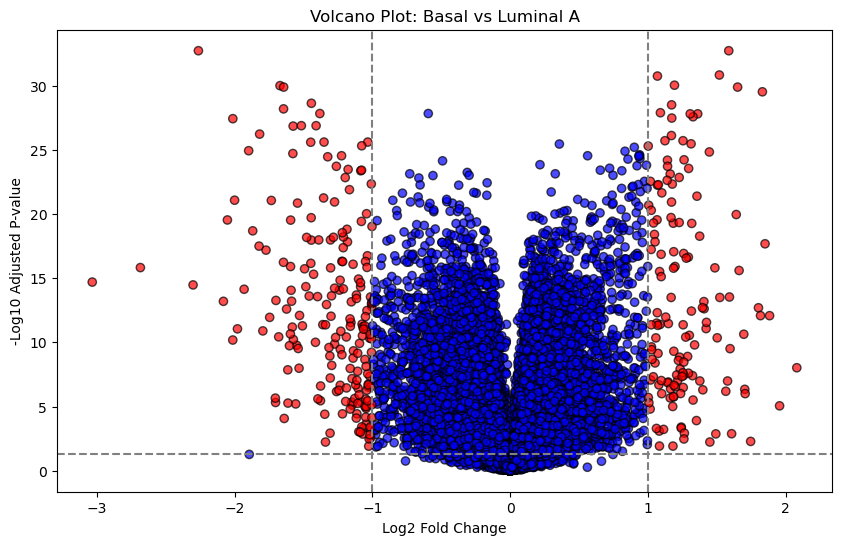

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(deg_df['log2FC'], -np.log10(deg_df['adj_p_value']), 
            c=(deg_df['adj_p_value'] < 0.05) & (deg_df['log2FC'].abs() > 1), 
            cmap='bwr', alpha=0.7, edgecolor='k')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot: Basal vs Luminal A')
plt.axhline(-np.log10(0.05), color='grey', linestyle='--')
plt.axvline(1, color='grey', linestyle='--')
plt.axvline(-1, color='grey', linestyle='--')
plt.show()


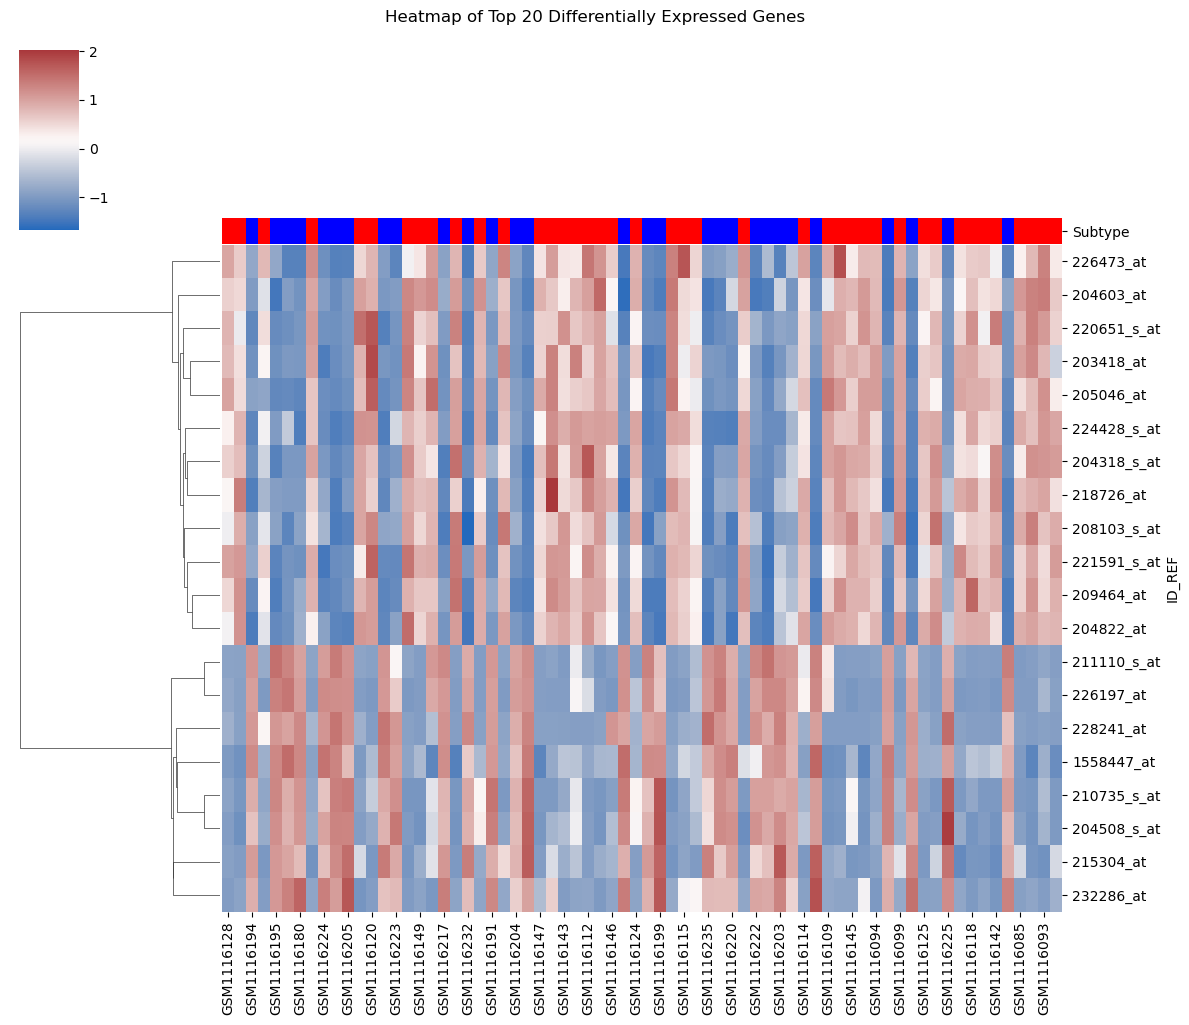

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Re-create color labels
group_colors = ['red' if s in basal_samples else 'blue' for s in heatmap_data.index]
group_df = pd.DataFrame({'Subtype': group_colors}, index=heatmap_data.index)

# Use clustermap for side colors
sns.clustermap(
    heatmap_data_z.T,
    cmap='vlag',
    row_cluster=True,
    col_cluster=False,
    col_colors=group_df['Subtype'],
    figsize=(12, 10)
)
plt.suptitle('Heatmap of Top 20 Differentially Expressed Genes', y=1.02)
plt.show()


In [29]:
!pip install gseapy


In [30]:
from statsmodels.stats.multitest import multipletests

# Add adjusted p-values
deg_df['adj_p_value'] = multipletests(deg_df['p_value'], method='fdr_bh')[1]

# Filter significant genes
significant_genes = deg_df[(deg_df['adj_p_value'] < 0.05) & (deg_df['log2FC'].abs() > 1)]

# Map to gene symbols
significant_genes = significant_genes.dropna(subset=['Gene_Symbol'])

# For Enrichr, remove multi-symbols like "MIR5193///UBA7"
gene_list = significant_genes['Gene_Symbol'].str.split('///').str[0].unique().tolist()

print(f"Number of DEGs used for enrichment: {len(gene_list)}")


Number of DEGs used for enrichment: 252


In [32]:
import gseapy as gp

# Run Enrichr using corrected parameters
enr = gp.enrichr(
    gene_list=gene_list,  # List of gene symbols
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='Human',  # Specify organism explicitly
    outdir='enrichr_results',  # Output directory for results
    cutoff=0.05  # Adjusted p-value cutoff for significance
)

# Display top results
enr.results.head(10)



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,microtubule cytoskeleton organization involved...,14/128,8.600287e-10,0.000001,0,0,10.131063,211.476369,CEP126;PLK1;TTK;AURKB;CDC20;CENPE;KIF4A;NUSAP1...
1,GO_Biological_Process_2021,mitotic spindle organization (GO:0007052),14/157,1.248901e-08,0.000010,0,0,8.064582,146.762633,CEP126;PLK1;TTK;AURKB;CDC20;TPX2;CENPE;KIF4A;C...
2,GO_Biological_Process_2021,regulation of chromosome segregation (GO:0051983),6/18,6.164870e-08,0.000034,0,0,40.113821,665.962187,KIF2C;CDC6;HORMAD1;MKI67;BUB1;AURKB
3,GO_Biological_Process_2021,spindle assembly checkpoint signaling (GO:0071...,5/21,5.266006e-06,0.001471,0,0,24.964575,303.425396,CDC20;PLK1;TTK;BUB1;MAD2L1
4,GO_Biological_Process_2021,mitotic spindle assembly checkpoint signaling ...,5/21,5.266006e-06,0.001471,0,0,24.964575,303.425396,CDC20;PLK1;TTK;BUB1;MAD2L1
5,GO_Biological_Process_2021,mitotic spindle checkpoint signaling (GO:0071174),5/21,5.266006e-06,0.001471,0,0,24.964575,303.425396,CDC20;PLK1;TTK;BUB1;MAD2L1
6,GO_Biological_Process_2021,negative regulation of mitotic metaphase/anaph...,5/22,6.744987e-06,0.001615,0,0,23.494880,279.746742,CDC20;PLK1;TTK;BUB1;MAD2L1
7,GO_Biological_Process_2021,regulation of metaphase/anaphase transition of...,3/8,1.056354e-04,0.022131,0,0,47.573494,435.559939,CENPE;PLK1;CDC6
8,GO_Biological_Process_2021,autonomic nervous system development (GO:0048483),4/21,1.244160e-04,0.023016,0,0,18.720114,168.329018,TFAP2B;SOX11;SOX8;GATA3
9,GO_Biological_Process_2021,positive regulation of cellular process (GO:00...,20/625,1.373263e-04,0.023016,0,0,2.727700,24.257849,SLC35F6;TFAP2B;DLX2;SLC44A4;KIF14;SOX11;TTK;IG...


<Axes: title={'center': 'GO Enrichment - Top 10'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

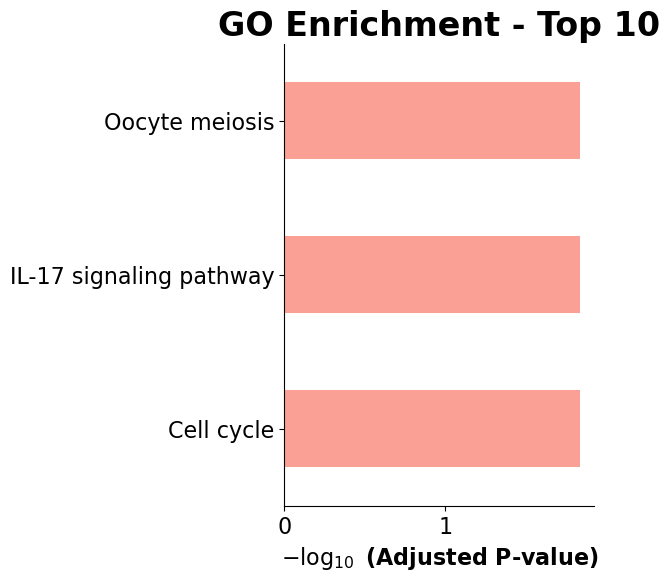

In [33]:
# Barplot of top 10 GO terms
gp.barplot(enr.res2d, title='GO Enrichment - Top 10', cutoff=0.05, top_term=10)


In [34]:
deg_df.to_csv("GSE45827_deg_results.csv", index=False)


In [35]:
significant_genes = deg_df[deg_df['adj_p_value'] < 0.05]
significant_genes.to_csv("GSE45827_significant_genes.csv", index=False)


In [36]:
plt.savefig("GSE45827_top20_heatmap.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [37]:
enr.results.to_csv("GSE45827_enrichment_results.csv", index=False)
